# Analysis of state-swtich dynamics
This is a notebook to study the swtich dynamics and recalling time, how long it lasts. In order to study it, it is necessary to study things on the middle of the sequence to see how they behave

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '0fb81389400864322b1944224935c76d3adba9e1'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from plotting_functions import plot_weight_matrix
from connectivity_functions import create_artificial_manager
from analysis_functions import calculate_recall_success_sequences, calculate_timings
from plotting_functions import plot_winning_pattern

In [4]:
def first_time(tau_z_pre, g_w, g_w_ampa, hypercolumns):
    
    alpha = (hypercolumns - 1.0) / hypercolumns
    
    return tau_z_pre * np.log(g_w / (g_w - g_w_ampa * alpha))

## Does switch state requieres adaptation?

In [15]:
hypercolumns = 4
minicolumns = 20
n_patterns = 20

dt = 0.001

beta = False
value = 2
inhibition = 0
extension = 1
decay_factor = 0.3
sequence_decay = 0.0

tau_z_pre = 0.150
g_a = 0
g_w = 1.0
g_w_ampa = 1.0
tau_a = 2.7
tau_m = 0.005
self_influence = False
G = 1.0

values_to_save = ['o', 's', 'z_pre', 'z_pre_ampa', 'z_post']

sequences = [[i for i in range(n_patterns)]]

manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value,
                                inhibition=inhibition,
                                extension=extension, decay_factor=decay_factor,
                                sequence_decay=sequence_decay,
                                dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True,
                                beta=beta, self_influence=self_influence, values_to_save=values_to_save)

manager.nn.tau_z_pre = tau_z_pre
manager.nn.g_a = g_a
manager.nn.g_w = g_w
manager.nn.g_w_ampa = g_w_ampa
manager.tau_a = tau_a
manager.tau_m = tau_m
manager.nn.G = G

manager.nn.get_parameters()

{'G': 1.0,
 'epsilon': 1e-20,
 'g_I': 10.0,
 'g_a': 0,
 'g_beta': 1,
 'g_w': 1.0,
 'g_w_ampa': 1.0,
 'k': 0.0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 5.0,
 'tau_z_post': 0.005,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 0.15,
 'tau_z_pre_ampa': 0.005}

In [16]:
n = 1
T_recall = 5.0
T_cue = 0.100

# manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=0, reset=True, empty_history=True)

successes = calculate_recall_success_sequences(manager, T_recall=T_recall, T_cue=T_cue, n=n, sequences=sequences)
print('success', successes)

('success', [0.0])


There is no correct recall without adaptation, the pattern never dies. 

Another interesting point is that if you **remove the inhibition** the process is still going on.

You need at least 4 hypercolumns for this to work.

Sequence recalls works even in absence of ampa

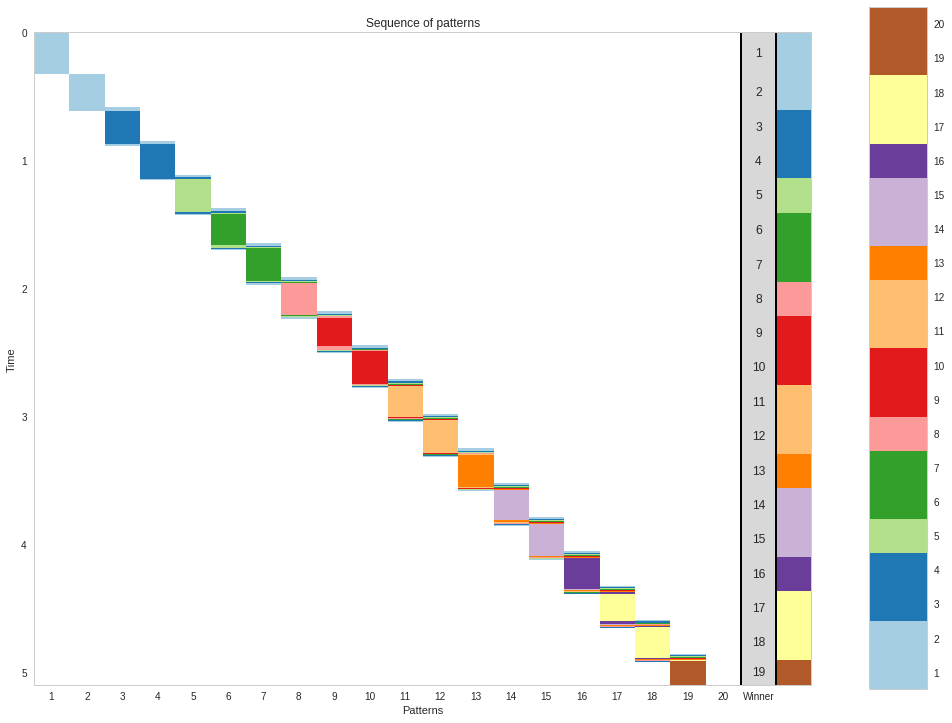

In [17]:
plot_winning_pattern(manager, remove=0.010)

In [18]:
aux = calculate_timings(manager, remove=0.010)
timings = [x[1] for x in aux]
mean = np.mean(timings[1:-1])

print('mean_time', mean)
theroetical_decay = first_time(tau_z_pre, g_w, g_w_ampa, hypercolumns)
print('decay', theroetical_decay)

('mean_time', 0.26964705882352941)
('decay', 0.20794415416798359)


In [19]:
manager.history['o'][90:200, 0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

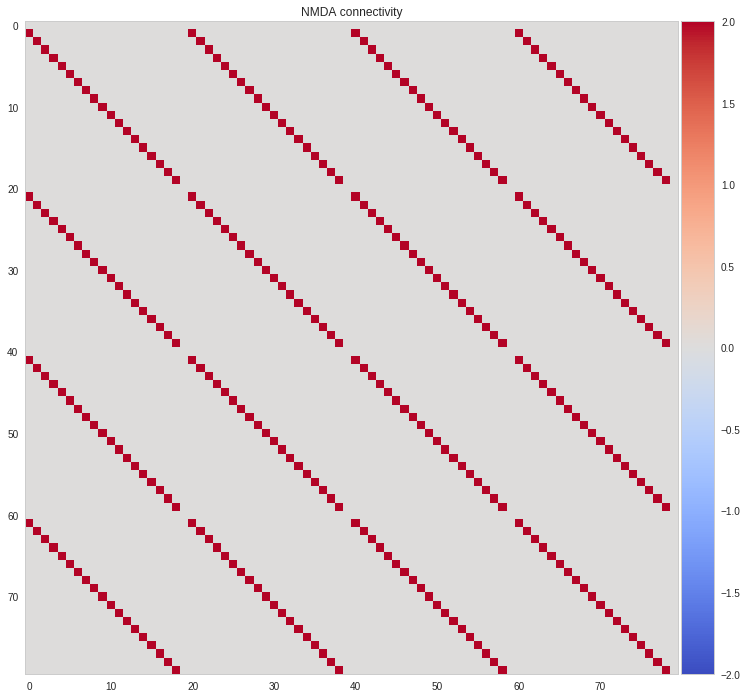

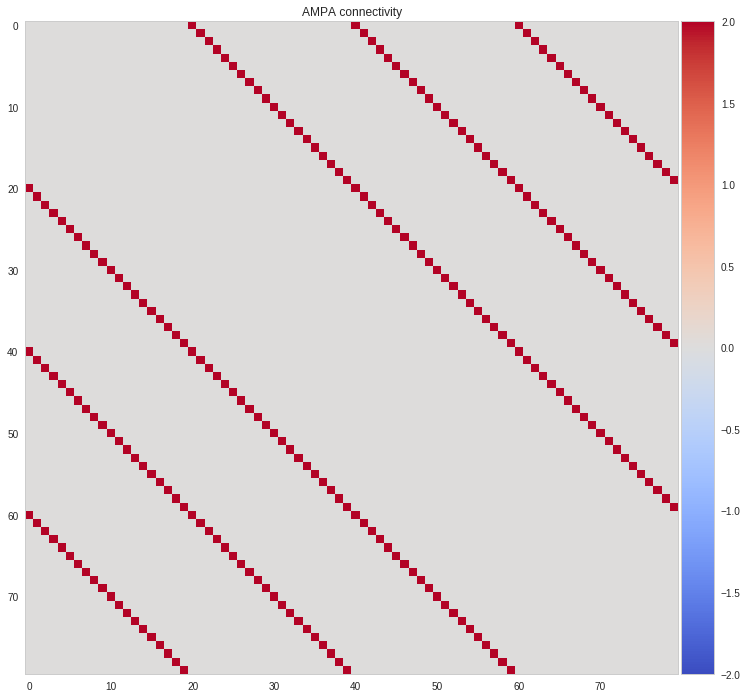

In [20]:
plot_weight_matrix(manager.nn, one_hypercolum=False)
plot_weight_matrix(manager.nn, ampa=True, one_hypercolum=False)

#### How do the dynamic quantities look like (z, z_ampa, o)?

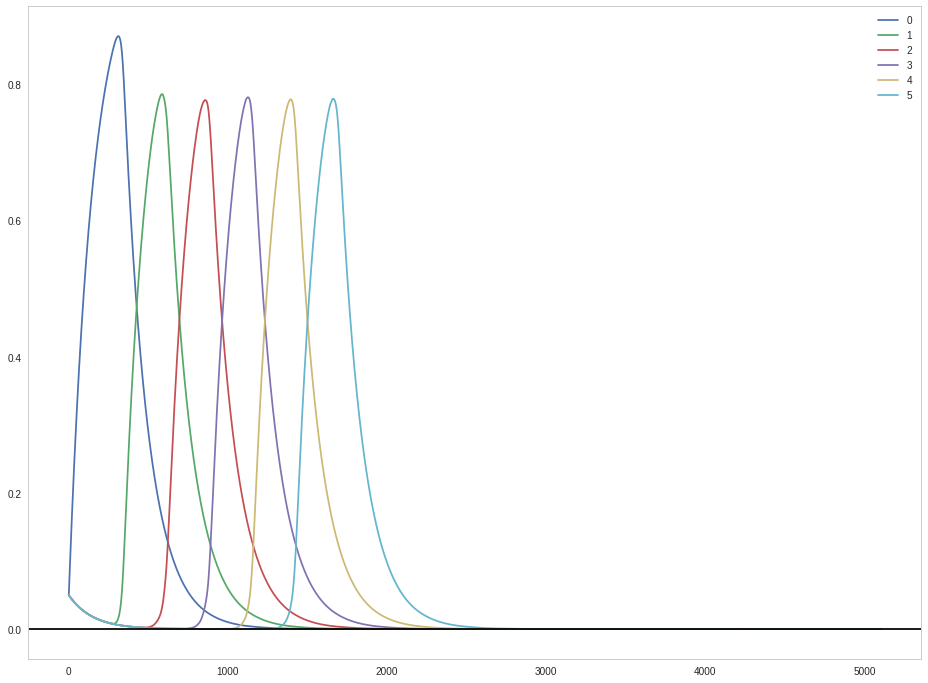

In [21]:
z_pre = manager.history['z_pre'][:, :6]
# z_pre = manager.history['z_pre'][:, :n_patterns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for z_index, z in enumerate(z_pre.T):
    ax.plot(z, label=str(z_index))

ax.axhline(0, color='black')
ax.legend();

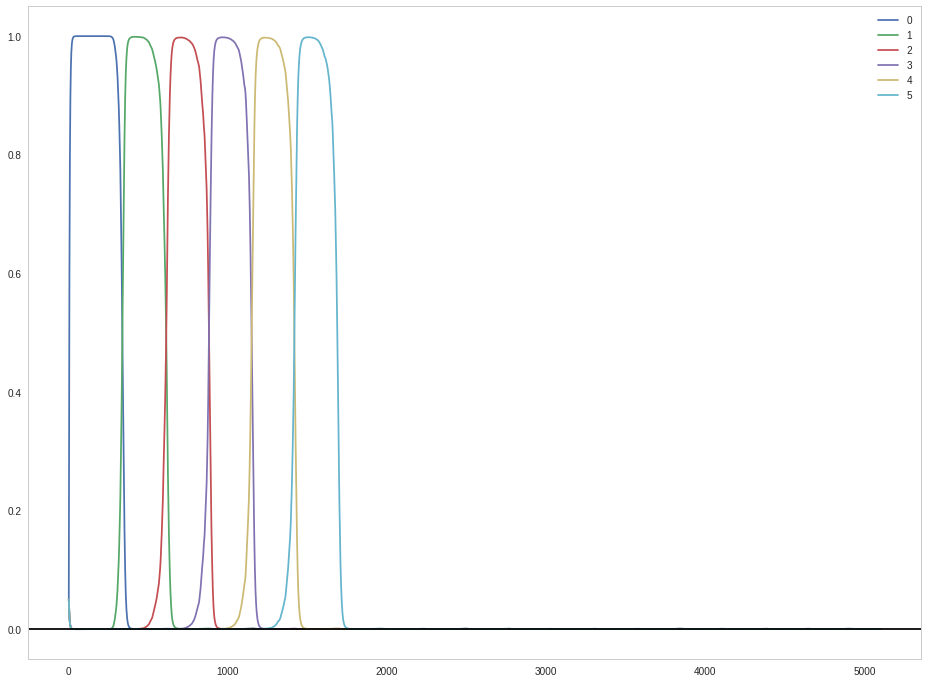

In [22]:
z_pre = manager.history['z_pre_ampa'][:, :6]
# z_pre = manager.history['z_pre'][:, :n_patterns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for z_index, z in enumerate(z_pre.T):
    ax.plot(z, label=str(z_index))

ax.axhline(0, color='black')
ax.legend();

#### o 

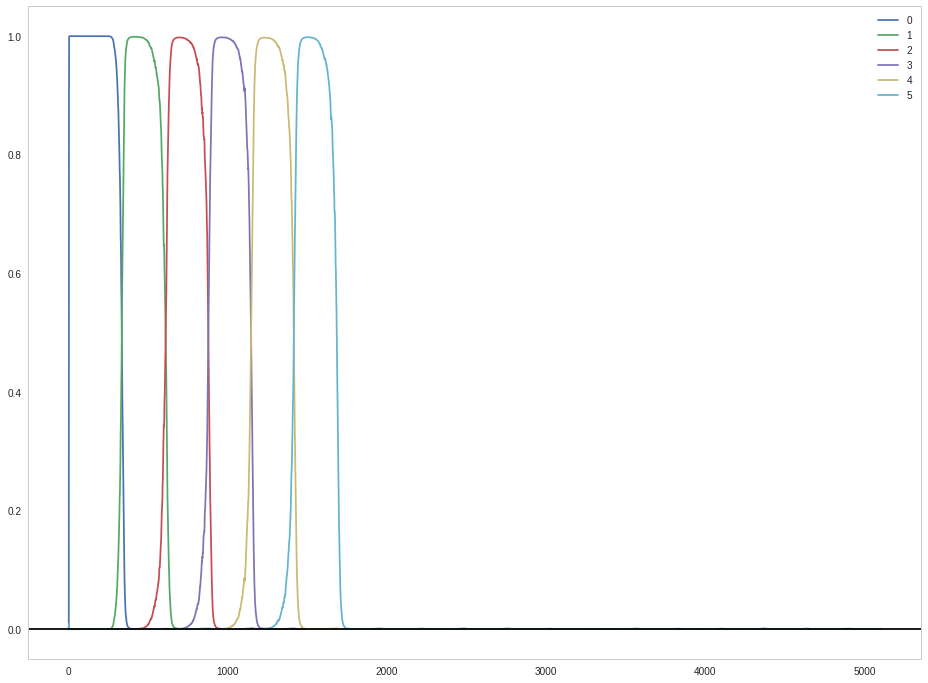

In [23]:
o = manager.history['o'][:, :6]
# z_pre = manager.history['z_pre'][:, :n_patterns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for o_index, o in enumerate(o.T):
    ax.plot(o, label=str(o_index))

ax.axhline(0, color='black')
ax.legend();

#### s

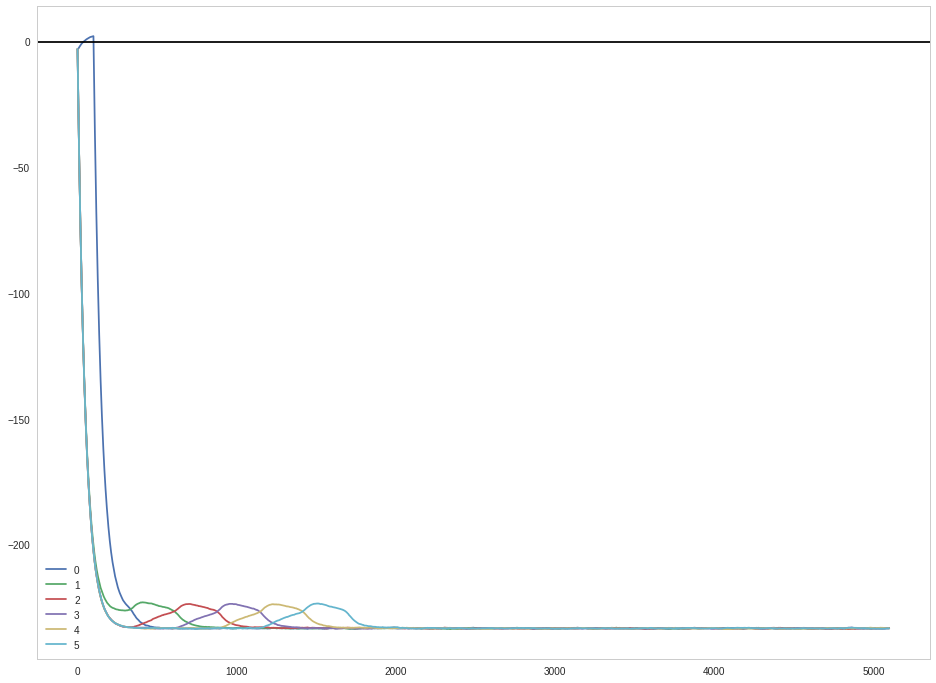

In [24]:
s = manager.history['s'][:, :6]
# z_pre = manager.history['z_pre'][:, :n_patterns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for s_index, s in enumerate(s.T):
    ax.plot(s, label=str(s_index))

ax.axhline(0, color='black')
ax.legend();

## No adaptation and no-cross effects 
This is one of the first attemps to validate a theoretical calculation for the recall time. In order to do it we assume:
* No adaptation
* No self nmda for the previous pattern 
* No ampa inhibition for the next pattern

In [167]:
hypercolumns = 4
minicolumns = 20
n_patterns = 20

dt = 0.001

beta = False
value = 2
inhibition = 0
extension = 1
decay_factor = 0.0
sequence_decay = 0.0

tau_z_pre = 0.150
g_a = 0
g_w = 1.0
g_w_ampa = 1.0
tau_a = 2.7
tau_m = 0.010
self_influence = False
G = 3.0

values_to_save = ['o']

sequences = [[i for i in range(n_patterns)]]

hypercolumns_range = np.arange(4, 15, 2)

In [168]:
means_simple = []
std_simple = []

for hypercolumns in hypercolumns_range:

    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value,
                                    inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor,
                                    sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True,
                                    beta=beta, self_influence=self_influence, values_to_save=values_to_save)

    manager.nn.tau_z_pre = tau_z_pre
    manager.nn.g_a = g_a
    manager.nn.g_w = g_w
    manager.nn.g_w_ampa = g_w_ampa
    manager.nn.tau_a = tau_a
    manager.nn.sigma = 0
    manager.nn.g_beta = 0
    manager.nn.tau_m = tau_m
    manager.nn.G = G

    n = 1
    T_recall = 5.0
    T_cue = 0.100

    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, T_cue=T_cue, n=n, sequences=sequences)
    aux = calculate_timings(manager, remove=0.010)
    timings = [x[1] for x in aux]
    mean = np.mean(timings[5:-5])
    std = np.std(timings[5:-5])
    
    means_simple.append(mean)
    std_simple.append(std)

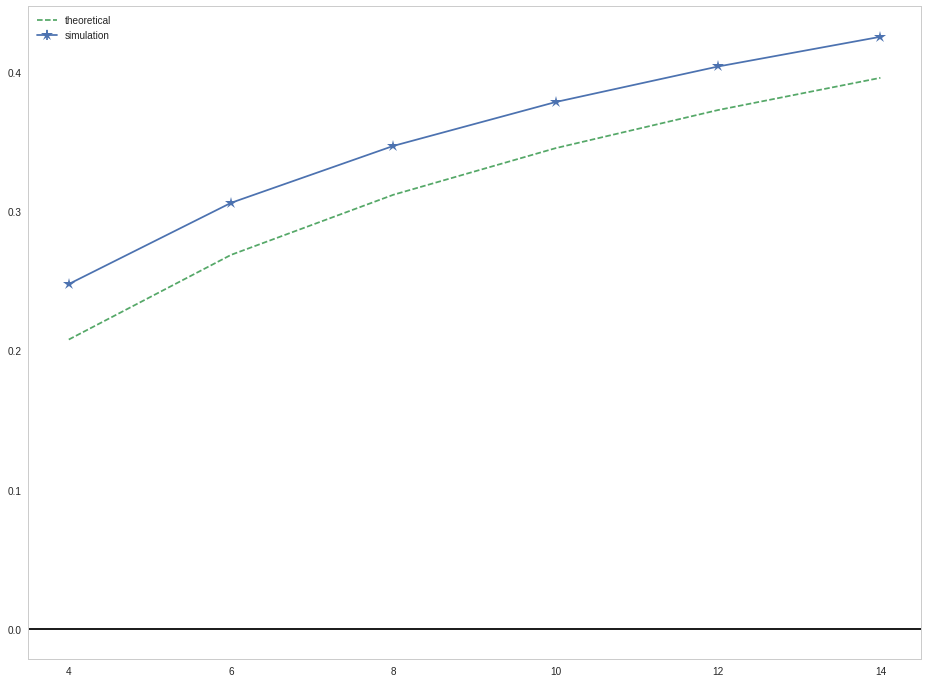

In [169]:
recall_time_theo = first_time(tau_z_pre, g_w, g_w_ampa, hypercolumns_range)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.errorbar(hypercolumns_range, means_simple, yerr=std_simple, fmt='*-', markersize=13, label='simulation')
ax.plot(hypercolumns_range, recall_time_theo, '--', label='theoretical')

ax.axhline(0, color='black')

ax.legend();

In [171]:
manager.nn.get_parameters()

{'epsilon': 1e-20,
 'g_I': 10.0,
 'g_a': 0,
 'g_beta': 0,
 'g_w': 1.0,
 'g_w_ampa': 1.0,
 'k': 0,
 'sigma': 0,
 'tau_a': 2.7,
 'tau_m': 0.01,
 'tau_p': 5.0,
 'tau_z_post': 0.005,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 0.15,
 'tau_z_pre_ampa': 0.005}

In [164]:
hypercolumns = 4
minicolumns = 20
n_patterns = 20

dt = 0.001

beta = False
value = 2
inhibition = 0
extension = 1
decay_factor = 0.0
sequence_decay = 0.0

tau_z_pre = 0.150
g_a = 0
g_w = 1.0
g_w_ampa = 1.0
tau_a = 2.7
tau_m = 0.010
self_influence = False
G = 3.0

values_to_save = ['o']

sequences = [[i for i in range(n_patterns)]]

g_w_range = np.arange(0.751, 1.5, 0.1)

In [165]:
means_simple_g_w = []
std_simple_g_w = []

for g_w in g_w_range:

    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value,
                                    inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor,
                                    sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True,
                                    beta=beta, self_influence=self_influence, values_to_save=values_to_save)

    manager.nn.tau_z_pre = tau_z_pre
    manager.nn.g_a = g_a
    manager.nn.g_w = g_w
    manager.nn.g_w_ampa = g_w_ampa
    manager.nn.tau_a = tau_a
    manager.nn.sigma = 0
    manager.nn.g_beta = 0
    manager.nn.tau_m = tau_m
    manager.nn.G = G

    n = 1
    T_recall = 5.0
    T_cue = 0.100

    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, T_cue=T_cue, n=n, sequences=sequences)
    aux = calculate_timings(manager, remove=0.010)
    timings = [x[1] for x in aux]
    mean = np.mean(timings[5:-5])
    std = np.std(timings[5:-5])
    
    means_simple_g_w.append(mean)
    std_simple_g_w.append(std)

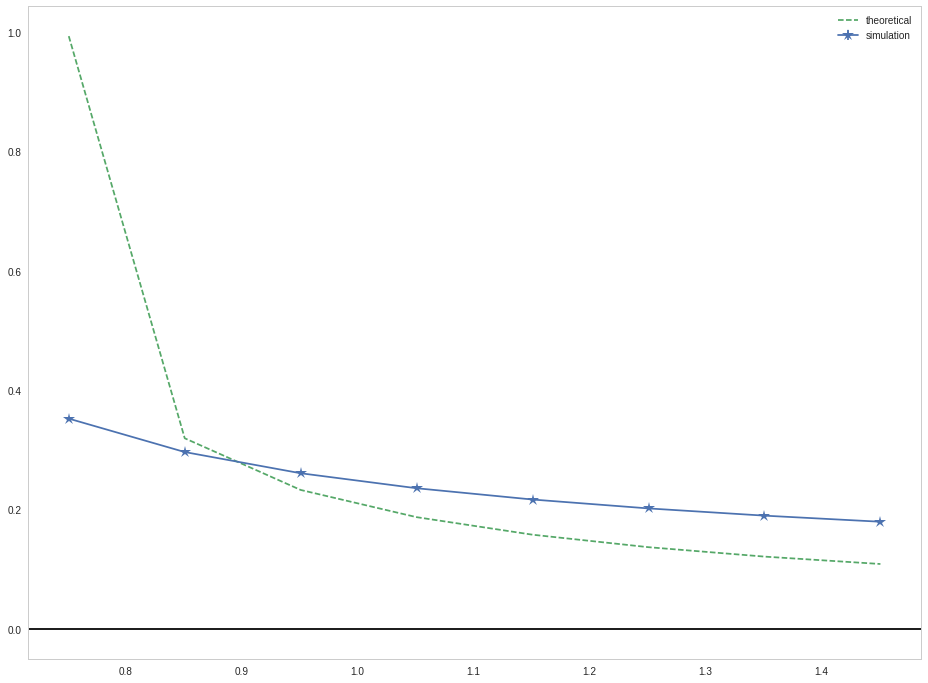

In [166]:
recall_time_theo = first_time(tau_z_pre, g_w_range, g_w_ampa, hypercolumns)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.errorbar(g_w_range, means_simple_g_w, yerr=std_simple_g_w, fmt='*-', markersize=13, label='simulation')
ax.plot(g_w_range, recall_time_theo, '--', label='theoretical')

ax.axhline(0, color='black')

ax.legend();

#### Git machinery

In [12]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])